- https://www.kaggle.com/datasets/lonnieqin/ump-combinatorialpurgedgroupkfold-tf-record

- https://www.kaggle.com/code/pythonash/end-to-end-simple-and-powerful-dnn-with-leakyrelu

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

### add random seed
tf.random.set_seed(3)
# tf.random.set_random_seed(3)

import sys
sys.path.append('../')
from model import model_conv2D

2022-05-05 13:32:47.379178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/lib:/usr/lib:
2022-05-05 13:32:47.379209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Configuration

If you want to train model, change 'is_trainig' to 'True'.

In [2]:
! ls ../data/input

CombinatorialPurgedGroupKFold_tf_record
ubiquant-market-prediction-half-precision-pickle


In [3]:
class Config:
#     is_training = False
    is_training = True
    tf_record_dataset_path = "../data/input/CombinatorialPurgedGroupKFold_tf_record/"
    ### change here ###
    output_dataset_path = "../data/model_wight/dnn-base-outputs/"
config = Config()

## Create an IntegerLookup layer for investment_id input

## Make Tensorflow dataset

In [4]:
%%time
investment_ids = pd.read_csv(config.tf_record_dataset_path + "investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

CPU times: user 174 ms, sys: 21.9 ms, total: 196 ms
Wall time: 193 ms


2022-05-05 13:32:49.171870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/lib:/usr/lib:
2022-05-05 13:32:49.171903: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-05 13:32:49.171923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-17-131): /proc/driver/nvidia/version does not exist
2022-05-05 13:32:49.172270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def decode_function(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )

def preprocess(item):
    return (item["investment_id"],item["features"]), item["target"]
# def preprocess(item):
#     return (item["features"]), item["target"]
def make_dataset(file_paths, batch_size=4096, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [6]:
ts = make_dataset(f"{config.tf_record_dataset_path}fold_0_train.tfrecords")

In [7]:
ts

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Modeling

I use layers.Conv1d. 

[source is here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)



In [8]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    ###    不偏分散にしたら？？   ###
    
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)

    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Let's take a look at this Model's architecture.

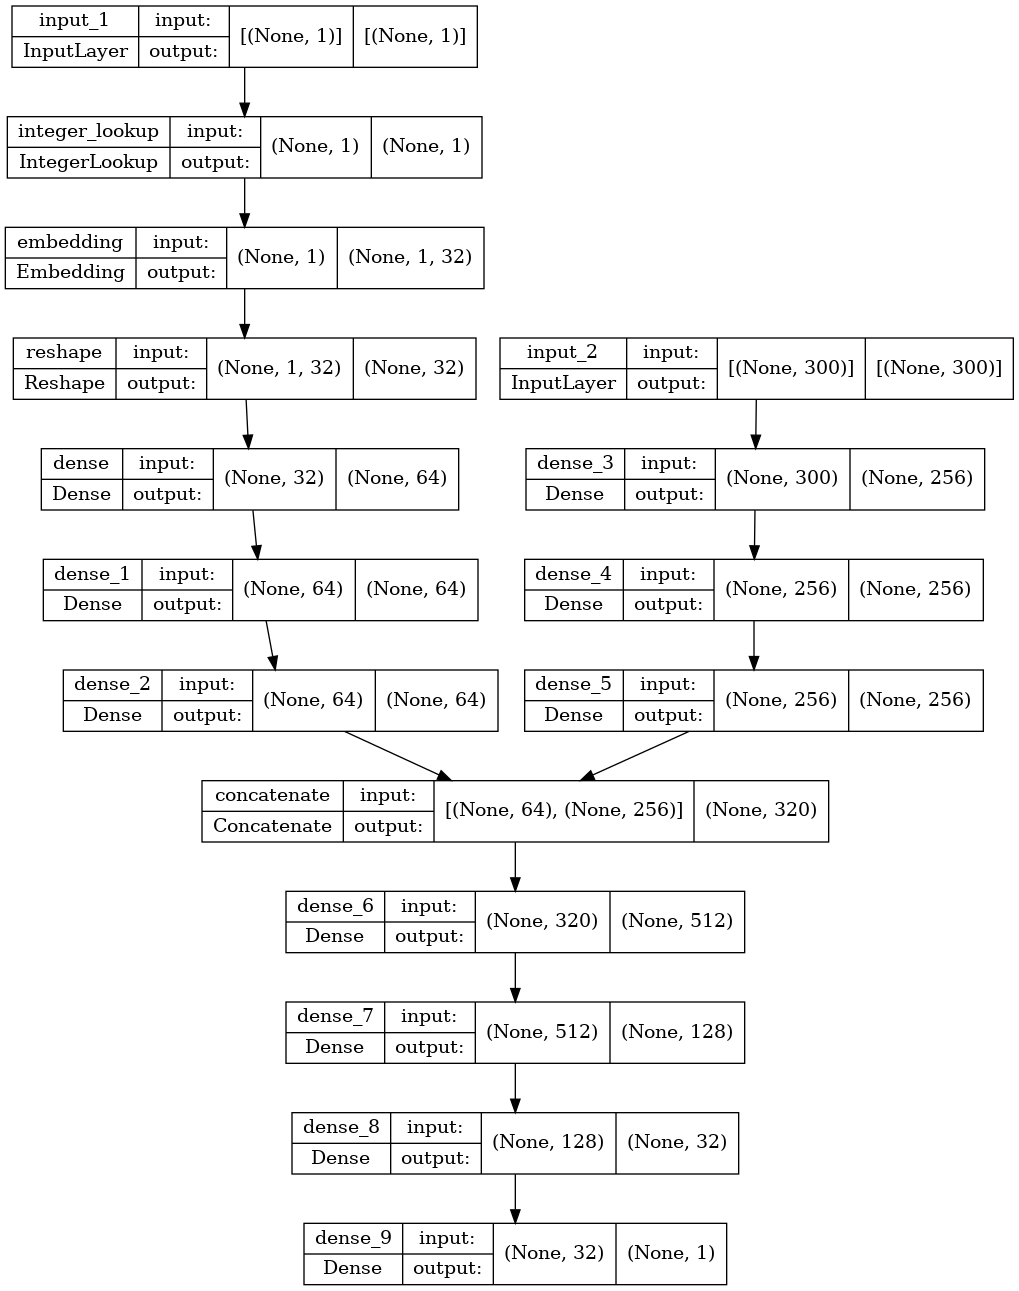

In [9]:
model = get_model()
# model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/50
627/627 [==============================] - 91s 143ms/step - loss: 1.1195 - mse: 0.8265 - mae: 0.6216 - mape: 135890.9062 - rmse: 0.9091 - correlation: 0.8679 - val_loss: 0.8660 - val_mse: 0.8637 - val_mae: 0.6439 - val_mape: 109572.2656 - val_rmse: 0.9294 - val_correlation: 0.9189
Epoch 2/50
627/627 [==============================] - 34s 54ms/step - loss: 0.8250 - mse: 0.8227 - mae: 0.6204 - mape: 154019.3594 - rmse: 0.9071 - correlation: 0.8543 - val_loss: 0.8651 - val_mse: 0.8632 - val_mae: 0.6440 - val_mape: 125436.4609 - val_rmse: 0.9291 - val_correlation: 0.9117
Epoch 3/50
627/627 [==============================] - 34s 54ms/step - loss: 0.8230 - mse: 0.8206 - mae: 0.6196 - mape: 160286.2188 - rmse: 0.9059 - correlation: 0.8455 - val_loss: 0.8646 - val_mse: 0.8627 - val_

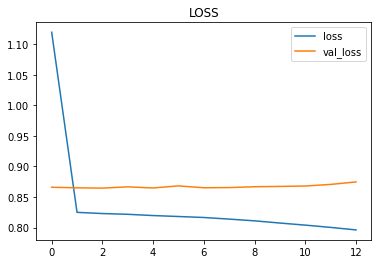

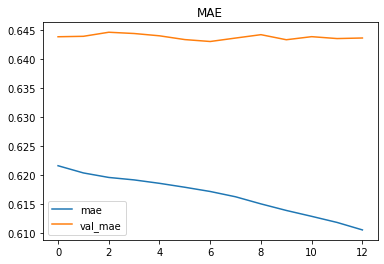

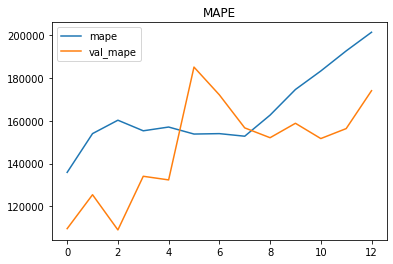

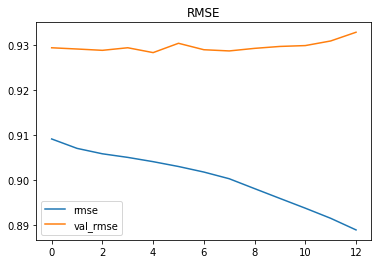

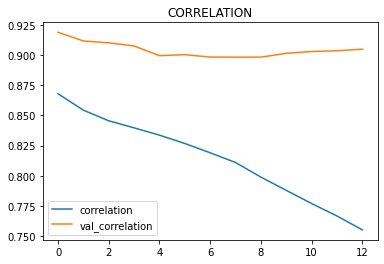

Pearson Score: 0.0960784511488094
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/50
637/637 [==============================] - 89s 138ms/step - loss: 1.1274 - mse: 0.8406 - mae: 0.6198 - mape: 129825.7891 - rmse: 0.9168 - correlation: 0.8779 - val_loss: 0.8049 - val_mse: 0.8038 - val_mae: 0.6637 - val_mape: 94626.3516 - val_rmse: 0.8965 - val_correlation: 0.8897
Epoch 2/50
637/637 [==============================] - 33s 51ms/step - loss: 0.8392 - mse: 0.8373 - mae: 0.6187 - mape: 146579.0156 - rmse: 0.9150 - correlation: 0.8646 - val_loss: 0.8032 - val_mse: 0.8023 - val_mae: 0.6625 - val_mape: 107678.9766 - val_rmse: 0.8957 - val_correlation: 0.8837
Epoch 3/50
637/637 [==============================] - 33s 51ms/step - loss: 0.8371 - mse: 0.8351 - mae: 0.6180 - mape: 147484.7656 - rmse: 0.9138 - correlation: 0.8555 - val_loss

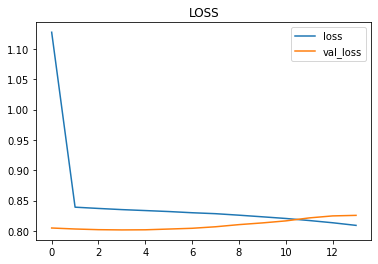

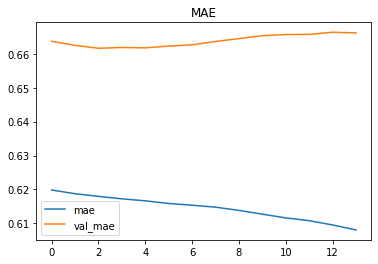

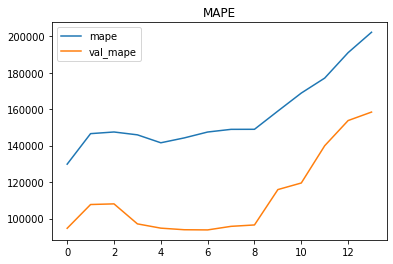

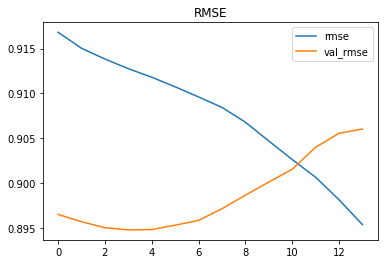

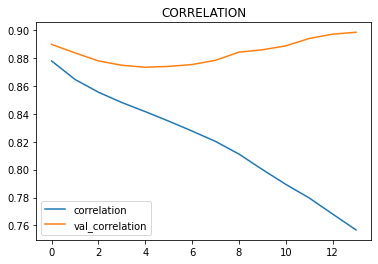

Pearson Score: 0.10316684162801323
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/50
611/611 [==============================] - 87s 140ms/step - loss: 1.1300 - mse: 0.8308 - mae: 0.6258 - mape: 105277.6719 - rmse: 0.9115 - correlation: 0.8736 - val_loss: 0.8474 - val_mse: 0.8462 - val_mae: 0.6293 - val_mape: 179020.9844 - val_rmse: 0.9199 - val_correlation: 0.8998
Epoch 2/50
611/611 [==============================] - 31s 52ms/step - loss: 0.8297 - mse: 0.8276 - mae: 0.6248 - mape: 119645.6172 - rmse: 0.9097 - correlation: 0.8612 - val_loss: 0.8462 - val_mse: 0.8450 - val_mae: 0.6296 - val_mape: 179110.6406 - val_rmse: 0.9193 - val_correlation: 0.8923
Epoch 3/50
611/611 [==============================] - 32s 52ms/step - loss: 0.8276 - mse: 0.8253 - mae: 0.6239 - mape: 131469.5312 - rmse: 0.9085 - correlation: 0.8517 - val_lo

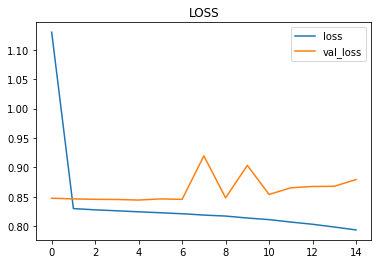

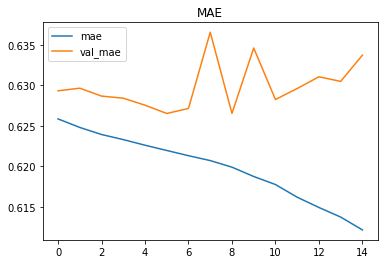

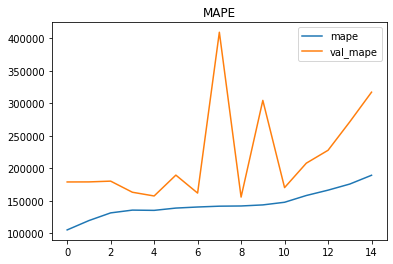

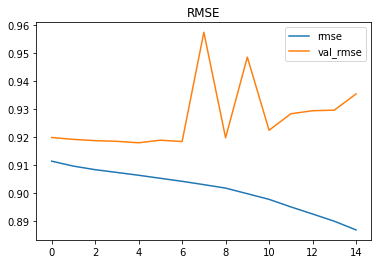

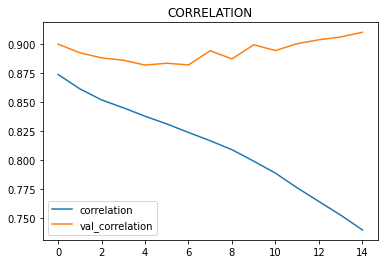

Pearson Score: 0.09108000734418245
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/50
584/584 [==============================] - 87s 146ms/step - loss: 1.1357 - mse: 0.8226 - mae: 0.6255 - mape: 95767.0234 - rmse: 0.9070 - correlation: 0.8611 - val_loss: 0.8661 - val_mse: 0.8643 - val_mae: 0.6260 - val_mape: 226707.5000 - val_rmse: 0.9297 - val_correlation: 0.9159
Epoch 2/50
584/584 [==============================] - 30s 51ms/step - loss: 0.8217 - mse: 0.8192 - mae: 0.6243 - mape: 101328.6250 - rmse: 0.9051 - correlation: 0.8489 - val_loss: 0.8652 - val_mse: 0.8636 - val_mae: 0.6255 - val_mape: 257879.9219 - val_rmse: 0.9293 - val_correlation: 0.9112
Epoch 3/50
584/584 [==============================] - 30s 52ms/step - loss: 0.8194 - mse: 0.8169 - mae: 0.6234 - mape: 103190.9062 - rmse: 0.9038 - correlation: 0.8403 - val_los

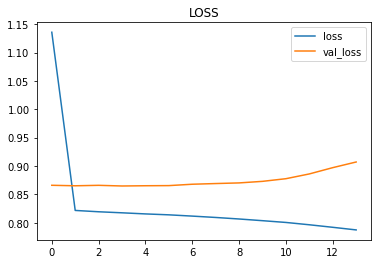

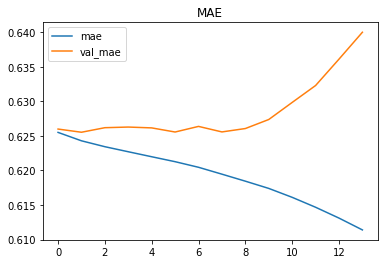

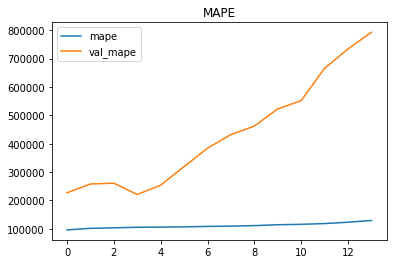

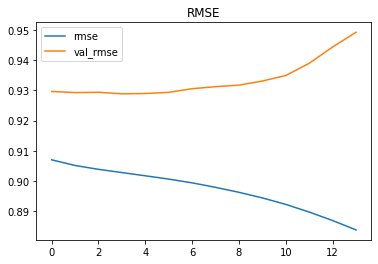

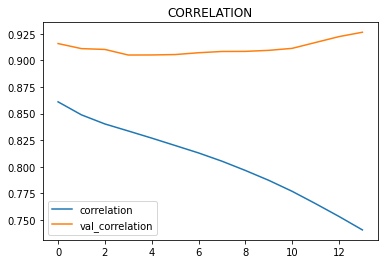

Pearson Score: 0.07411542065759137
<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/50
577/577 [==============================] - 100s 172ms/step - loss: 1.1588 - mse: 0.8406 - mae: 0.6332 - mape: 131382.6562 - rmse: 0.9168 - correlation: 0.8731 - val_loss: 0.8159 - val_mse: 0.8133 - val_mae: 0.6017 - val_mape: 161659.3125 - val_rmse: 0.9018 - val_correlation: 0.8866
Epoch 2/50
577/577 [==============================] - 32s 55ms/step - loss: 0.8389 - mse: 0.8366 - mae: 0.6317 - mape: 155908.1406 - rmse: 0.9146 - correlation: 0.8582 - val_loss: 0.8144 - val_mse: 0.8124 - val_mae: 0.6001 - val_mape: 175494.2656 - val_rmse: 0.9013 - val_correlation: 0.8767
Epoch 3/50
577/577 [==============================] - 32s 55ms/step - loss: 0.8365 - mse: 0.8344 - mae: 0.6308 - mape: 164797.7969 - rmse: 0.9135 - correlation: 0.8500 - val_l

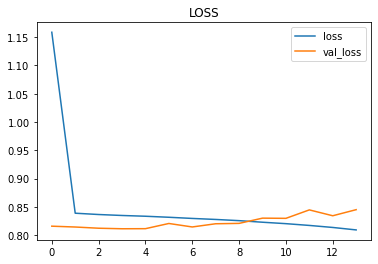

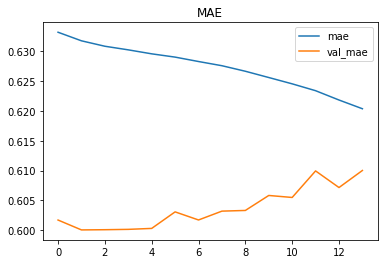

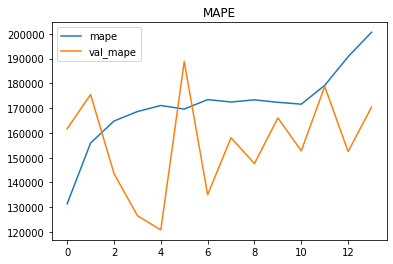

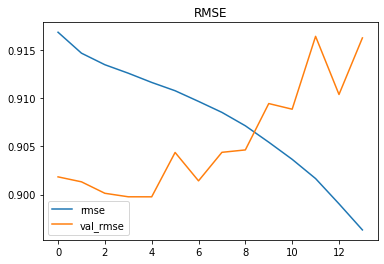

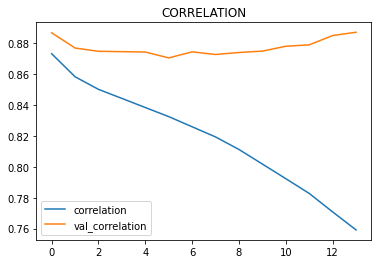

Pearson Score: 0.11461053635498457
CPU times: user 4h 11min 14s, sys: 29min 1s, total: 4h 40min 16s
Wall time: 42min 41s


In [10]:
%%time
models = []
for i in range(5):
    train_path = f"{config.tf_record_dataset_path}fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    print(valid_ds)
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        checkpoint = keras.callbacks.ModelCheckpoint(f"{config.output_dataset_path}model_{i}.tf",
                                                     monitor="val_correlation",
                                                     mode="min", 
                                                     save_best_only=True, 
                                                     save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=10)
        history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
#         model.save_weights(f"{config.output_dataset_path}model_{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}model_{i}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")
